In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from sklearn.metrics.pairwise import laplacian_kernel
from scipy.stats import sem, t
#from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import shap
import optuna

In [2]:
dbnsfp_data = '/projects/wangc/rohan/missense_prediction/disorder/disorder/dbNSFP/dbNSFP4.8a_variant.disorder_genes.tsv'
AF2_disorder_data = '/projects/wangc/rohan/missense_prediction/disorder/disorder/output/AF2_disorder_albatross_features.csv'
refseq_enst_data = '/projects/wangc/rohan/missense_prediction/disorder/disorder/gene2refseq/mart_export.ensemble_refseq.mapping.tsv'
ref_ps_data = '/projects/wangc/rohan/missense_prediction/disorder/disorder/alphafold/ref_disorder_phase_separation.tsv'
mut_ps_data = '/projects/wangc/rohan/missense_prediction/disorder/disorder/alphafold/mut_disorder_phase_separation.tsv'
#../output/AF2_Disorder_deleterious_neutral_vus_results_filtered.tsv

In [3]:
AF2_df = pd.read_csv(AF2_disorder_data)
mane_df = pd.read_csv(refseq_enst_data, sep='\t')
mane_df = mane_df[['Transcript_stable_ID_version', 'MANE_Select']]
AF2_df = pd.merge(AF2_df, mane_df, left_on='CAVA_TRANSCRIPT', right_on='MANE_Select', how='left')

#gene_transcript_dict = dict(zip(AF2_df['GENES'], AF2_df['Transcript_stable_ID_version']))
#dbnsfp_df
AF2_df.columns

Index(['mutation', 'Class', 'UNIPROT_ID', 'GENES', 'CHROM', 'GSTART', 'GEND',
       'CAVA_PROTALT', 'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_TRANSCRIPT', 'WT',
       'mut_seq', 'wt_asphericity', 'mut_asphericity', 'wt_radius_of_gyration',
       'mut_radius_of_gyration', 'wt_end_to_end_distance',
       'mut_end_to_end_distance', 'wt_scaling_exponent',
       'mut_scaling_exponent', 'wt_prefactor', 'mut_prefactor',
       'delta_asphericity', 'delta_radius_of_gyration',
       'delta_end_to_end_distance', 'delta_scaling_exponent',
       'delta_prefactor', 'abs_delta_asphericity',
       'abs_delta_radius_of_gyration', 'abs_delta_end_to_end_distance',
       'abs_delta_scaling_exponent', 'abs_delta_prefactor',
       'Transcript_stable_ID_version', 'MANE_Select'],
      dtype='object')

In [10]:
def preprocess_dbNSFP(dbNSFP_df, gene, transcript):
    required_columns = ['aaref', 'aaalt', 'aapos', 'genename', 'Ensembl_transcriptid',
                        'gnomAD_exomes_AC', 'gnomAD_exomes_AN', 'gnomAD_exomes_AF',
                        'clinvar_clnsig']

    is_rankscore_column = [column for column in dbNSFP_df.columns if column.endswith('rankscore')]
    required_columns += is_rankscore_column

    dbNSFP_req_df = dbNSFP_df[required_columns].copy()

    dbNSFP_req_df.loc[:, 'aapos'] = dbNSFP_req_df['aapos'].str.split(';')
    dbNSFP_req_df.loc[:, 'Ensembl_transcriptid'] = dbNSFP_req_df['Ensembl_transcriptid'].str.split(';')
    dbNSFP_req_df.loc[:, 'genename'] = dbNSFP_req_df['genename'].str.split(';')

    columns_to_explode = ['aapos', 'Ensembl_transcriptid', 'genename']
    dbNSFP_req_df = dbNSFP_req_df.apply(lambda x: x.explode() if x.name in columns_to_explode else x)

    dbNSFP_req_df = dbNSFP_req_df[
        (dbNSFP_req_df['genename'] == gene) & 
        (dbNSFP_req_df['Ensembl_transcriptid'] == transcript)
    ]

    dbNSFP_req_df = dbNSFP_req_df[~dbNSFP_req_df['aapos'].isna()]
    dbNSFP_req_df.loc[:, 'aapos'] = dbNSFP_req_df['aapos'].astype(int)
    dbNSFP_req_df = dbNSFP_req_df[dbNSFP_req_df['aapos'] >= 0]
    dbNSFP_req_df.loc[:, 'aapos'] = dbNSFP_req_df['aapos'].astype(str)

    dbNSFP_req_df.loc[:, 'mutations'] = (
        dbNSFP_req_df['aaref'] + dbNSFP_req_df['aapos'] + dbNSFP_req_df['aaalt']
    )
 
    dbNSFP_req_df = dbNSFP_req_df.replace(".", np.nan)
    dbNSFP_req_df.loc[:, 'aapos'] = dbNSFP_req_df['aapos'].astype(int)
    columns_to_fillna = ['gnomAD_exomes_AC', 'gnomAD_exomes_AN', 'gnomAD_exomes_AF', 'clinvar_clnsig'] + is_rankscore_column
    dbNSFP_req_df.loc[:, columns_to_fillna] = dbNSFP_req_df[columns_to_fillna].fillna(0)

    dbNSFP_req_df = dbNSFP_req_df.drop_duplicates().reset_index(drop=True)

    return dbNSFP_req_df

In [11]:
dbnsfp_df = pd.read_csv(dbnsfp_data, sep='\t')


/tmp/ipykernel_84991/2325655048.py:1: DtypeWarning: Columns (0,1,7,8,9,10,11,26,30,31,40,41,49,50,52,53,54,58,59,61,62,64,65,67,68,69,70,72,73,75,76,77,82,83,91,92,98,99,101,102,104,105,107,108,110,111,113,114,115,116,117,118,119,120,121,122,140,141,142,143,150,151,152,153,154,155,156,157,158,159,162,163,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,192,193,194,195,196,197,198,199,200,201,202,203,205,206,207,208) have mixed types. Specify dtype option on import or set low_memory=False.
  dbnsfp_df = pd.read_csv(dbnsfp_data, sep='\t')


In [101]:
#dbnsfp_dir = "/projects/wangc/rohan/missense_prediction/disorder/disorder/dbNSFP/processed"

# List all TSV files in the directory
#processed_files = [f for f in os.listdir(dbnsfp_dir) if f.endswith(".tsv")]


# Read and concatenate all TSV files
#df_dbnsfp_list = [pd.read_csv(os.path.join(dbnsfp_dir, file), sep="\t") for file in processed_files]
#dbnsfpt_gene_df = pd.concat(df_dbnsfp_list, ignore_index=True)
#dbnsfpt_gene_df.to_csv("../alphafold/dbNSFP_disorder_genes.tsv", sep='\t', index=None)

In [12]:
dbnsfpt_gene_df = pd.read_csv("../alphafold/dbNSFP_disorder_genes.tsv", sep='\t')


In [45]:
AF2_keep_df = AF2_df[AF2_df['Class'] != 'VUS']
AF2_keep_df['label']= AF2_keep_df["Class"].map({"Deleterious": 1, "Neutral": 0})
AF2_keep_df.columns
#dbnsfpt_gene_df.columns

Index(['mutation', 'Class', 'UNIPROT_ID', 'GENES', 'CHROM', 'GSTART', 'GEND',
       'CAVA_PROTALT', 'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_TRANSCRIPT', 'WT',
       'mut_seq', 'wt_asphericity', 'mut_asphericity', 'wt_radius_of_gyration',
       'mut_radius_of_gyration', 'wt_end_to_end_distance',
       'mut_end_to_end_distance', 'wt_scaling_exponent',
       'mut_scaling_exponent', 'wt_prefactor', 'mut_prefactor',
       'delta_asphericity', 'delta_radius_of_gyration',
       'delta_end_to_end_distance', 'delta_scaling_exponent',
       'delta_prefactor', 'abs_delta_asphericity',
       'abs_delta_radius_of_gyration', 'abs_delta_end_to_end_distance',
       'abs_delta_scaling_exponent', 'abs_delta_prefactor',
       'Transcript_stable_ID_version', 'MANE_Select', 'label'],
      dtype='object')

In [46]:
# Extract unique gene names from each DataFrame
genes_af2 = set(AF2_keep_df['GENES'].unique())  # Genes from AF2_keep_df
genes_dbnsfp = set(dbnsfpt_gene_df['genename'].unique())  # Genes from dbnsfpt_gene_df

# Find genes that are unique to AF2_keep_df
unique_genes_af2 = genes_af2 - genes_dbnsfp

list(set(AF2_keep_df[AF2_keep_df['GENES'].isin(unique_genes_af2)]['GENES'].tolist()))


['ITGB2', 'STING1', 'PTEN', 'PEX5', 'PRDM2', 'NOTCH1']

In [47]:
# Extract relevant predictor columns
dbnsfp_predictors = [column for column in dbnsfpt_gene_df.columns if column.endswith('rankscore')]

# Merge AF2_df with dbNSFP data
AF2_disorder_dbnsfp_df = pd.merge(
    AF2_keep_df, dbnsfpt_gene_df, left_on=['GENES', 'mutation'], right_on=['genename', 'mutations'], how='left'
)
AF2_disorder_dbnsfp_df = AF2_disorder_dbnsfp_df.groupby(['mutations', 'GENES', 'label']).first().reset_index()

existing_rankscore_columns = [col for col in dbnsfp_predictors if col in AF2_disorder_dbnsfp_df.columns]
existing_rankscore_columns = existing_rankscore_columns + ['mutations', 'GENES', 'label']

AF2_disorder_dbnsfp_pred_df = AF2_disorder_dbnsfp_df[existing_rankscore_columns].dropna().reset_index(drop=True)

AF2_disorder_dbnsfp_df.to_csv("../output/data_used_study.csv", index=False)
AF2_disorder_dbnsfp_df#.columns.to_list()


,mutations,GENES,label,mutation,Class,UNIPROT_ID,CHROM,GSTART,GEND,CAVA_PROTALT,...,GERP++_RS_rankscore,GERP_91_mammals_rankscore,phyloP100way_vertebrate_rankscore,phyloP470way_mammalian_rankscore,phyloP17way_primate_rankscore,phastCons100way_vertebrate_rankscore,phastCons470way_mammalian_rankscore,phastCons17way_primate_rankscore,SiPhy_29way_logOdds_rankscore,bStatistic_converted_rankscore
0,A1011E,TSC1,0,A1011E,Neutral,Q92574,chr9,964,1164,E,...,0.57399,0.38459,0.34025,0.35768,0.76740,0.32681,0.30280,0.91618,0.51303,0.20147
1,A102T,E2F1,0,A102T,Neutral,Q01094,chr20,1,129,T,...,0.63643,0.92802,0.38254,0.50968,0.40250,0.36153,0.68203,0.42306,0.72029,0.94257
2,A1034T,GLI3,0,A1034T,Neutral,P10071,chr7,946,1580,T,...,0.46262,0.43096,0.32736,0.23892,0.32500,0.06391,0.08366,0.02609,0.47052,0.14249
3,A1039T,GLI3,0,A1039T,Neutral,P10071,chr7,946,1580,T,...,0.14400,0.11320,0.07188,0.12261,0.09497,0.06391,0.08366,0.02609,0.03380,0.14249
4,A103V,EHMT1,0,A103V,Neutral,Q9H9B1,chr9,1,523,V,...,0.00728,0.03764,0.05933,0.04170,0.09056,0.06391,0.08366,0.32885,0.85864,0.03397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,Y828C,LDLR,1,Y828C,Deleterious,P01130,chr19,720,860,C,...,0.60666,0.86246,0.93611,0.00000,0.85281,0.71638,0.68203,0.46843,0.61667,0.74455
2100,Y828H,LDLR,1,Y828H,Deleterious,P01130,chr19,720,860,H,...,0.60666,0.00000,0.85003,0.00000,0.49286,0.71638,0.68203,0.46004,0.61667,0.74455
2101,Y828S,LDLR,1,Y828S,Deleterious,P01130,chr19,720,860,S,...,0.60666,0.86246,0.93611,0.00000,0.85281,0.71638,0.68203,0.46843,0.61667,0.74455
2102,Y856H,BRCA1,0,Y856H,Neutral,P38398,chr17,103,1396,H,...,0.46415,0.79359,0.50987,0.29374,0.84096,0.71638,0.31174,0.71098,0.46289,0.75131


In [83]:
group_bar_df = AF2_disorder_dbnsfp_df[['GENES', 'Class']]
group_bar_counts = pd.crosstab(index=group_bar_df["GENES"], columns=group_bar_df["Class"]).reset_index()
group_bar_counts.to_csv("../output/data_genes_count.csv", index=False)

In [25]:
AF2_disorder_dbnsfp_pred_df.to_csv("../output/mutation_data_with_dnsfp_scores.csv", index=None)
duplicate_counts = AF2_disorder_dbnsfp_pred_df.groupby(['mutations', 'GENES', 'label']).size().reset_index(name='count')
duplicates = duplicate_counts[duplicate_counts['count'] > 1]
AF2_disorder_dbnsfp_pred_df.label.value_counts()

0    1788
1     316
Name: label, dtype: int64

In [48]:
def calculate_auc_with_ci(df, column, label, random_state=42):
    np.random.seed(random_state)  # Set the seed for reproducibility
    
    aucs = []
    pr_aucs = []
    max_f1_scores = []  
    fprs = []  # False Positive Rate
    n_bootstrap = 200
    
    for _ in range(n_bootstrap):
        # Separate the data into positive and negative classes
        positive = df[df[label] == 1]
        negative = df[df[label] == 0]
        min_size = min(len(positive), len(negative))
        positive_resampled = resample(positive, replace=False, n_samples=min_size)
        negative_resampled = resample(negative, replace=False, n_samples=min_size)
        sample = pd.concat([positive_resampled, negative_resampled])
        sample = resample(sample, replace=True)
        sample = sample.dropna(subset=[label, column])
        if sample.empty:
            continue
        try:
            # Calculate AUC and PR AUC
            auc = roc_auc_score(sample[label], sample[column])
            aucs.append(auc)
            pr_auc = average_precision_score(sample[label], sample[column])
            pr_aucs.append(pr_auc)
            
            # Calculate FPR, TPR, and F1 Score at thresholds
            fpr, tpr, thresholds = roc_curve(sample[label], sample[column])
            specificity = 1 - fpr
            f1_scores_at_thresholds = 2 * (tpr * specificity) / (tpr + specificity + 1e-10)  
            max_f1_index = np.argmax(f1_scores_at_thresholds)
            max_f1 = f1_scores_at_thresholds[max_f1_index]
            max_f1_scores.append(max_f1)
            
            # Calculate False Positive Rate (FPR) at max F1 threshold
            fprs.append(fpr[max_f1_index])  # Store FPR at the threshold where F1 is maximized
            
        except ValueError:
            pass
    
    # Calculate Confidence Intervals for metrics
    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))
    max_f1_ci = t.interval(0.95, len(max_f1_scores) - 1, loc=np.mean(max_f1_scores), scale=sem(max_f1_scores))
    fpr_ci = t.interval(0.95, len(fprs) - 1, loc=np.mean(fprs), scale=sem(fprs))

    return (
        np.mean(aucs), auc_ci,
        np.mean(pr_aucs), pr_auc_ci,
        np.mean(max_f1_scores), max_f1_ci,
        np.mean(fprs), fpr_ci
    )

def calculate_metrics_and_store(results_df, dbnsfp_predictors, label_col, result_type):
    data_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                 'PR_AUC_low': [], 'PR_AUC_high': [],  'F1_Score': [],
                 'F1_CI_low': [], 'F1_CI_high': [], 'FRP_Score': [], 'FRP_CI_low': [],'FRP_CI_high': [],'TYPE': []}

    for predictor in dbnsfp_predictors:
        # Call the function to calculate metrics
        aucs, auc_ci, pr_aucs, pr_auc_ci, f1, f1_ci, fpr, fpr_ci = calculate_auc_with_ci(results_df, 
                                                                                        predictor, label_col)
        # Store the calculated values in the dictionary
        data_dict['name'].append(predictor)
        data_dict['AUC'].append(aucs)
        data_dict['AUC_CI_low'].append(auc_ci[0])
        data_dict['AUC_CI_high'].append(auc_ci[1])
        data_dict['PI_AUC'].append(pr_aucs)
        data_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_dict['F1_Score'].append(f1)
        data_dict['F1_CI_low'].append(f1_ci[0])
        data_dict['F1_CI_high'].append(f1_ci[1])
        data_dict['FRP_Score'].append(fpr)
        data_dict['FRP_CI_low'].append(fpr_ci[0])
        data_dict['FRP_CI_high'].append(fpr_ci[1])
        data_dict['TYPE'].append(result_type)
    
    # Convert the dictionary into a DataFrame and return it sorted by AUC
    result_df = pd.DataFrame(data_dict)
    result_df = result_df.sort_values(by="AUC", ascending=False)
    
    return result_df


In [49]:
dbnsfp_predictors =  [column for column in AF2_disorder_dbnsfp_pred_df.columns if column.endswith('rankscore')]

AF2_disorder_dbnsfp_pred_df[dbnsfp_predictors] = AF2_disorder_dbnsfp_pred_df[dbnsfp_predictors].astype(float)
result_disorder_df = calculate_metrics_and_store(AF2_disorder_dbnsfp_pred_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')


/projects/wangc/rohan/miniconda3/envs/soursop/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/projects/wangc/rohan/miniconda3/envs/soursop/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [50]:
result_disorder_df.to_csv("../output/dbnsfp_results.csv", index=None)
result_disorder_df[result_disorder_df['name'] == 'EVE']

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,F1_Score,F1_CI_low,F1_CI_high,FRP_Score,FRP_CI_low,FRP_CI_high,TYPE


/projects/wangc/rohan/miniconda3/envs/soursop/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/projects/wangc/rohan/miniconda3/envs/soursop/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


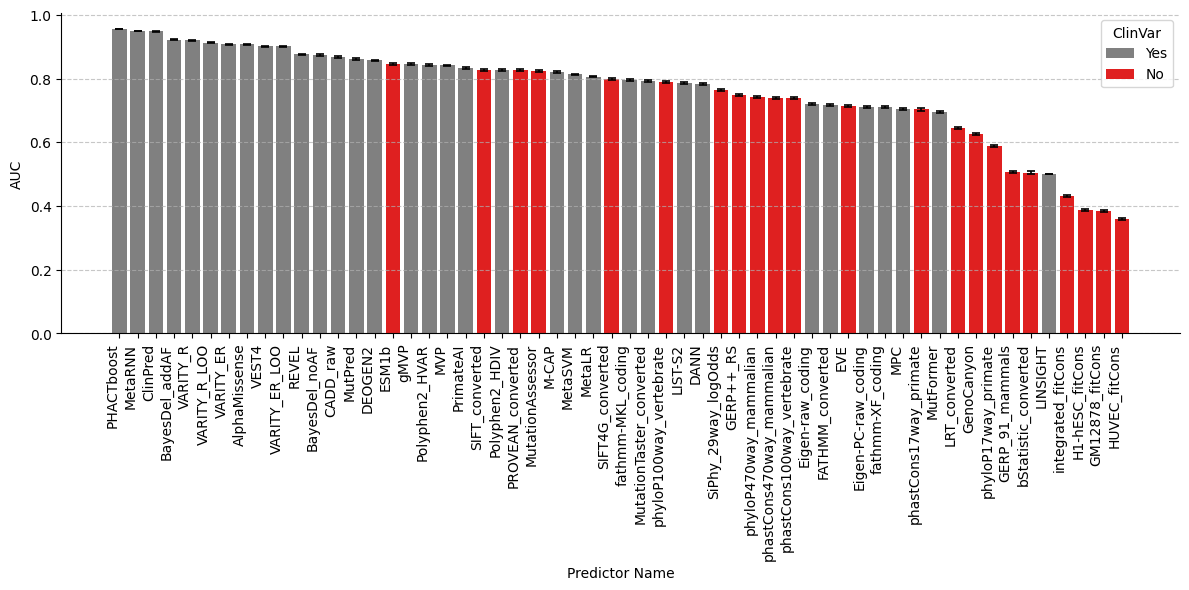

In [51]:
dbnsfp_predictors =  [column for column in AF2_disorder_dbnsfp_pred_df.columns if column.endswith('rankscore')]

AF2_disorder_dbnsfp_pred_df[dbnsfp_predictors] = AF2_disorder_dbnsfp_pred_df[dbnsfp_predictors].astype(float)
result_disorder_df = calculate_metrics_and_store(AF2_disorder_dbnsfp_pred_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')
result_disorder_df
non_clinvar = ['SIFT_converted_rankscore', 'SIFT4G_converted_rankscore',
               'LRT_converted_rankscore', 'PROVEAN_converted_rankscore', 'MutationAssessor_rankscore', 'GenoCanyon_rankscore',
                     'ESM1b_rankscore', 'EVE_rankscore','integrated_fitCons_rankscore', 'GM12878_fitCons_rankscore',
                     'H1-hESC_fitCons_rankscore', 'HUVEC_fitCons_rankscore','GERP++_RS_rankscore',
                     'GERP_91_mammals_rankscore','phyloP100way_vertebrate_rankscore',
                     'phyloP470way_mammalian_rankscore','phyloP17way_primate_rankscore',
                     'phastCons100way_vertebrate_rankscore',
                     'phastCons470way_mammalian_rankscore','phastCons17way_primate_rankscore','SiPhy_29way_logOdds_rankscore',
                     'bStatistic_converted_rankscore']




# Create a new column to define colors based on the unsupervised list
result_disorder_df['Clinvar'] = result_disorder_df['name'].apply(
    lambda x: 'No' if x in non_clinvar else 'Yes'
)
result_disorder_df['name'] = result_disorder_df['name'].str.replace('_rankscore', '', regex=False)

# Initialize the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=result_disorder_df, 
    x='name', 
    y='AUC', 
    hue='Clinvar', 
    dodge=False, 
    errorbar=None, palette={"No": "red", "Yes": "grey"}
)

# Ensure x-coordinates match the number of bars
x_coords = np.arange(len(result_disorder_df))  # Numeric x-axis positions
y_values = result_disorder_df['AUC'].values
y_err_lower = (result_disorder_df['AUC'] - result_disorder_df['AUC_CI_low']).values
y_err_upper = (result_disorder_df['AUC_CI_high'] - result_disorder_df['AUC']).values

plt.errorbar(
    x=x_coords, 
    y=y_values, 
    yerr=[y_err_lower, y_err_upper], 
    fmt='none', ecolor='black', capsize=3, elinewidth=1.2, capthick=1.2
)

# Formatting
plt.xticks(rotation=90, ha="right")
plt.xlabel("Predictor Name")
plt.ylabel("AUC")
#plt.title("AUC for mutations in disordered regions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="ClinVar")
sns.despine()
plt.tight_layout()
plt.savefig("AUC_dbsnsfp_disorder.png", dpi=300)
# Show plot
plt.show()

/tmp/ipykernel_84991/271690276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_disorder_supervised_df['is_supervised'] = result_disorder_df['name'].apply(


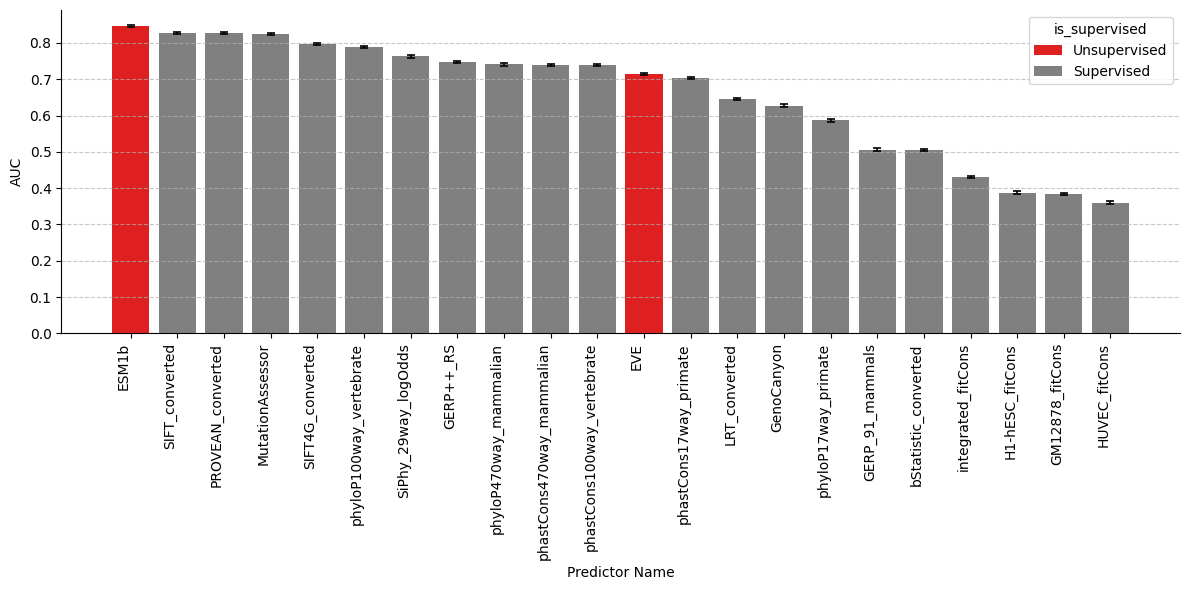

In [52]:
unsupervised_list = ['ESM1b', "EVE"]

result_disorder_supervised_df = result_disorder_df[result_disorder_df['Clinvar'] == 'No']
result_disorder_supervised_df['is_supervised'] = result_disorder_df['name'].apply(
    lambda x: 'Unsupervised' if x in unsupervised_list else 'Supervised'
)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=result_disorder_supervised_df, 
    x='name', 
    y='AUC', 
    hue='is_supervised', 
    dodge=False, 
    errorbar=None, palette={"Unsupervised": "red", "Supervised": "grey"}
)

# Ensure x-coordinates match the number of bars
x_coords = np.arange(len(result_disorder_supervised_df))  # Numeric x-axis positions
y_values = result_disorder_supervised_df['AUC'].values
y_err_lower = (result_disorder_supervised_df['AUC'] - result_disorder_supervised_df['AUC_CI_low']).values
y_err_upper = (result_disorder_supervised_df['AUC_CI_high'] - result_disorder_supervised_df['AUC']).values

plt.errorbar(
    x=x_coords, 
    y=y_values, 
    yerr=[y_err_lower, y_err_upper], 
    fmt='none', ecolor='black', capsize=3, elinewidth=1.2, capthick=1.2
)

# Formatting
plt.xticks(rotation=90, ha="right")
plt.xlabel("Predictor Name")
plt.ylabel("AUC")
#plt.title("AUC for mutations in disordered regions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="is_supervised")
sns.despine()
plt.tight_layout()
plt.savefig("AUC_dbsnsfp_disorder_unsupervised.png", dpi=300)
# Show plot
plt.show()

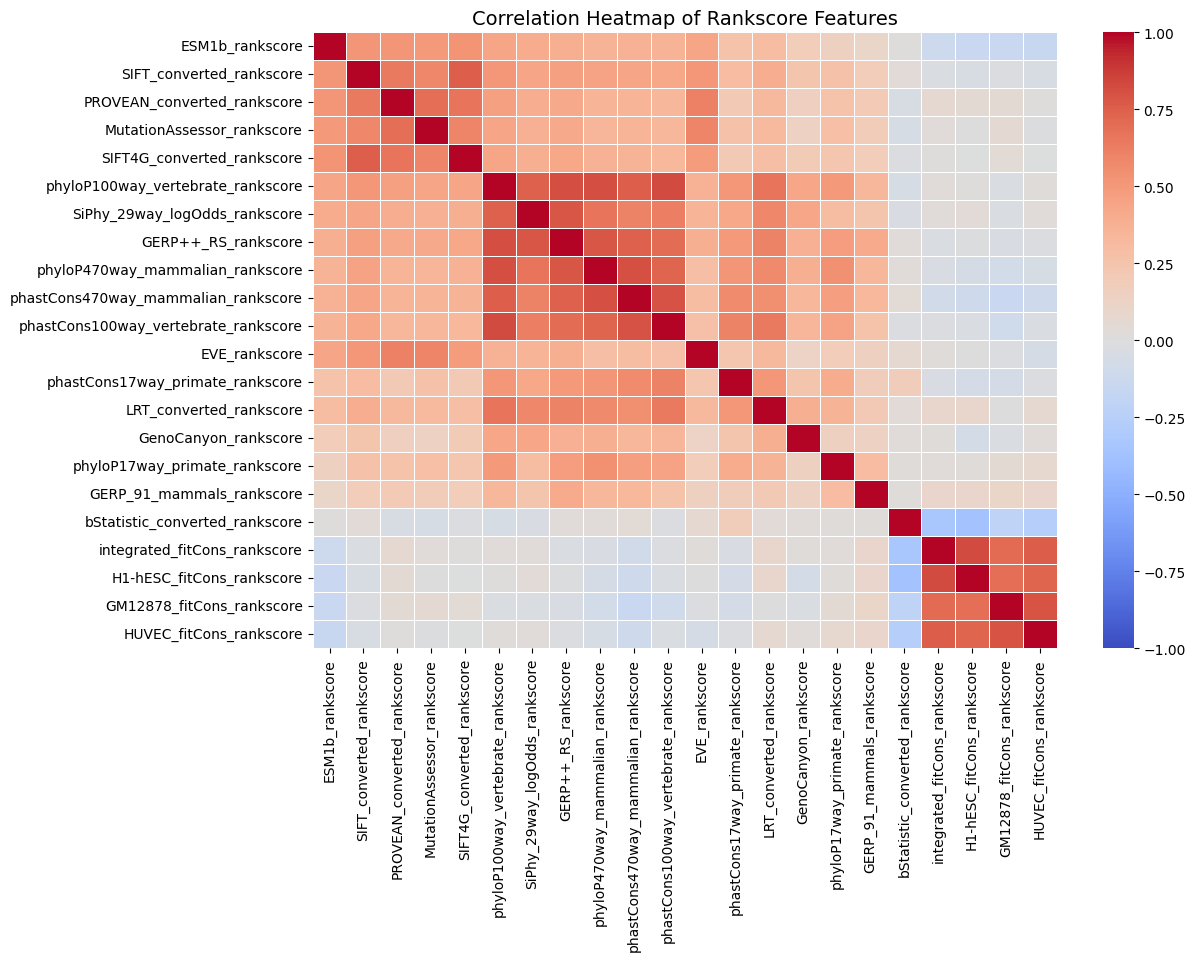

In [53]:
col_name = [i + "_rankscore" for i in result_disorder_supervised_df.name.tolist()]

#AF2_disorder_dbnsfp_pred_df[col_name]
selected_df = AF2_disorder_dbnsfp_pred_df[col_name]

# Compute the correlation matrix
corr_matrix = selected_df.corr()

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(
    corr_matrix, 
    annot=False,  # Show correlation values
    fmt=".2f",  # Limit decimal places
    cmap="coolwarm",  # Choose color scheme
    linewidths=0.5,  # Add grid lines
    vmin=-1, vmax=1  # Set correlation range
)

# Set title
plt.title("Correlation Heatmap of Rankscore Features", fontsize=14)

# Show the plot
plt.show()

In [54]:
AF2_disorder_dbnsfp_insilico_df = AF2_disorder_dbnsfp_df[['ESM1b_rankscore', 'EVE_rankscore', 'mutation', 'Class', 'WT', 'mut_seq',
                                                          'abs_delta_asphericity', 'abs_delta_radius_of_gyration',
                                                          'abs_delta_end_to_end_distance','abs_delta_scaling_exponent','abs_delta_prefactor',
                                                          'integrated_fitCons_rankscore',
                                                          'GM12878_fitCons_rankscore',
                                                          'H1-hESC_fitCons_rankscore',
                                                          'HUVEC_fitCons_rankscore',
                                                          'LINSIGHT_rankscore','GERP++_RS_rankscore',
                                                          'GERP_91_mammals_rankscore',
                                                          'phyloP100way_vertebrate_rankscore',
                                                          'phyloP470way_mammalian_rankscore',
                                                          'phyloP17way_primate_rankscore',
                                                          'phastCons100way_vertebrate_rankscore',
                                                          'phastCons470way_mammalian_rankscore',
                                                          'phastCons17way_primate_rankscore',
                                                          'SiPhy_29way_logOdds_rankscore','bStatistic_converted_rankscore','label']]



In [55]:
def compute_metrics_cv(dataframe, predictor_col, class_col, n_splits=5, random_state=None):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Prepare metrics storage
    metrics_list = []

    # Extract predictor and class columns
    X = dataframe[predictor_col].values.astype(float)  # Ensure predictor is float
    y = dataframe[class_col].values

    # Iterate through the stratified folds
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        # Split the data into train and test sets
        y_true = y[test_index]
        y_pred = X[test_index]
        
        # Calculate metrics
        if len(np.unique(y_true)) == 1:
            # Skip fold if the test set has only one class
            continue
        auc = roc_auc_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, np.round(y_pred))
        
        # Store metrics
        metrics_list.append({
            'fold': fold,
            'auc': auc,
            'accuracy': accuracy
        })

    # Convert metrics to DataFrame
    results_df = pd.DataFrame(metrics_list)
    return results_df

In [56]:
eve_only_df = compute_metrics_cv(AF2_disorder_dbnsfp_insilico_df, predictor_col='EVE_rankscore', 
                                                    class_col='label', n_splits=10, random_state=42)
eve_only_df['method'] = 'EVE'
eve_only_df['model'] = 'EVE'
esm1b_only_df = compute_metrics_cv(AF2_disorder_dbnsfp_insilico_df, predictor_col='ESM1b_rankscore', 
                                   class_col='label', n_splits=10, random_state=42)
esm1b_only_df['method'] = 'ESM1B'
esm1b_only_df['model'] ='ESM1B'

/tmp/ipykernel_84991/305559582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AF2_disorder_dbnsfp_insilico_df['size'] = AF2_disorder_dbnsfp_insilico_df['WT'].str.len()
/tmp/ipykernel_84991/305559582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_dist_df['label'] = plot_dist_df['label'].replace({1: 'Deleterious', 0: 'Benign'})
/tmp/ipykernel_84991/305559582.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to

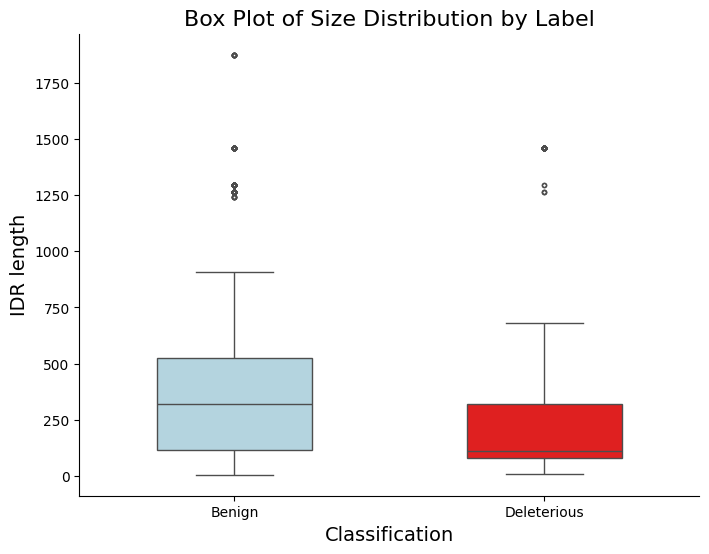

In [57]:
AF2_disorder_dbnsfp_insilico_df['size'] = AF2_disorder_dbnsfp_insilico_df['WT'].str.len()
plot_dist_df = AF2_disorder_dbnsfp_insilico_df[['label', 'size']]
# Rename labels for clarity
plot_dist_df['label'] = plot_dist_df['label'].replace({1: 'Deleterious', 0: 'Benign'})

# Set figure size
plt.figure(figsize=(8, 6))

# Create box plot
sns.boxplot(
    data=plot_dist_df, 
    x="label", 
    y="size",
    width=0.5,  # Adjust box width
    fliersize=3,  # Adjust outlier size
    palette={"Deleterious": "red", "Benign": "lightblue"}  # Custom colors
)

# Labels and Title
plt.xlabel("Classification", fontsize=14)
plt.ylabel("IDR length", fontsize=14)
plt.title("Box Plot of Size Distribution by Label", fontsize=16)

# Remove top & right spines
sns.despine()
plt.savefig("IDR_length_by_type.png", dpi=300)
# Show the plot
plt.show()

In [58]:
feature_cols_eve = [ 'EVE_rankscore', 
                'abs_delta_asphericity', 'abs_delta_radius_of_gyration',
                'abs_delta_end_to_end_distance','abs_delta_scaling_exponent','abs_delta_prefactor']

feature_cols_esm1b = ['ESM1b_rankscore','abs_delta_asphericity', 'abs_delta_radius_of_gyration',
                'abs_delta_end_to_end_distance','abs_delta_scaling_exponent','abs_delta_prefactor']

def create_train_test(data, feature_cols, target_col, test_size=0.2, random_state=42 ):
    X = data[feature_cols]
    y = data[target_col]
    
    # Encode the target if necessary
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test


def train_xgboost_with_cv(X, y, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_metrics = []
    models = []
    metrics_list = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        #print(f"Training fold {fold + 1}/{n_splits}")
        
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize and train the XGBoost classifier
        model = XGBClassifier(
            use_label_encoder=False, 
            eval_metric='logloss', 
            random_state=random_state
        )
        model.fit(X_train, y_train)
        models.append(model)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        #print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}")
        
        # Append metrics
        metrics_list.append({
            'fold': fold,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        })
    results_df = pd.DataFrame(metrics_list)
    return results_df, model
    
def train_random_forest_with_cv(X, y, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_metrics = []
    models = []
    metrics_list = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        #print(f"Training fold {fold + 1}/{n_splits}")
        
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize and train the Random Forest classifier
        model = RandomForestClassifier(random_state=random_state)
        model.fit(X_train, y_train)
        models.append(model)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Append metrics
        metrics_list.append({
            'fold': fold,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        })
    results_df = pd.DataFrame(metrics_list)
    return results_df, models


def train_mlp_with_cv(X, y, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_metrics = []
    models = []
    metrics_list = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        #print(f"Training fold {fold + 1}/{n_splits}")
        
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize and train the MLP classifier
        model = MLPClassifier(random_state=random_state, max_iter=1000)
        model.fit(X_train, y_train)
        models.append(model)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Append metrics
        metrics_list.append({
            'fold': fold,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        })
    results_df = pd.DataFrame(metrics_list)
    return results_df, models

In [59]:
X_train_esm, X_test_esm, y_train_esm, y_test_esm = create_train_test(AF2_disorder_dbnsfp_insilico_df, feature_cols_eve, 'Class')
X_train_esm1b, X_test_esm1b, y_train_esm1b, y_test_esm1b = create_train_test(AF2_disorder_dbnsfp_insilico_df, feature_cols_esm1b, 'Class')
X_eve = AF2_disorder_dbnsfp_insilico_df[feature_cols_eve]
X_esm1b = AF2_disorder_dbnsfp_insilico_df[feature_cols_esm1b]
X_eve = X_eve.apply(pd.to_numeric, errors='coerce')
X_esm1b = X_esm1b.apply(pd.to_numeric, errors='coerce')
y = AF2_disorder_dbnsfp_insilico_df['Class']
# Encode target labels if necessary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Perform 5-fold y_eve_encoded
fold_metrics_eve_xg_df, models_eve_xg = train_xgboost_with_cv(X_eve, y_encoded, n_splits=10, random_state=42)
fold_metrics_esm1b_xg_df, models_esm1b_xg = train_xgboost_with_cv(X_esm1b, y_encoded, n_splits=10, random_state=42)
fold_metrics_eve_rf_df, models_eve_rf = train_random_forest_with_cv(X_eve, y_encoded, n_splits=10, random_state=42)
fold_metrics_esm1b_rf_df, models_esm1b_rf = train_random_forest_with_cv(X_esm1b, y_encoded, n_splits=10, random_state=42)
fold_metrics_eve_mlp_df, models_eve_mlp = train_mlp_with_cv(X_eve, y_encoded, n_splits=10, random_state=42)
fold_metrics_esm1b_mlp_df, models_esm1b_mlp = train_mlp_with_cv(X_esm1b, y_encoded, n_splits=10, random_state=42)
fold_metrics_eve_xg_df.columns = ['fold', 'accuracy', 'auc']
fold_metrics_eve_xg_df['method'] = 'pIDRc + EVE'
fold_metrics_eve_xg_df['model'] = 'xgboost'
fold_metrics_esm1b_xg_df.columns = ['fold', 'accuracy', 'auc']
fold_metrics_esm1b_xg_df['method'] = 'pIDRc + ESM1B'
fold_metrics_esm1b_xg_df['model'] = 'xgboost'

fold_metrics_eve_rf_df.columns = ['fold', 'accuracy', 'auc']
fold_metrics_eve_rf_df['method'] = 'pIDRc + EVE'
fold_metrics_eve_rf_df['model'] = 'Random Forest'
fold_metrics_esm1b_rf_df.columns = ['fold', 'accuracy', 'auc']
fold_metrics_esm1b_rf_df['method'] = 'pIDRc + ESM1B'
fold_metrics_esm1b_rf_df['model'] = 'Random Forest'


fold_metrics_eve_mlp_df.columns = ['fold', 'accuracy', 'auc']
fold_metrics_eve_mlp_df['method'] = 'pIDRc + EVE'
fold_metrics_eve_mlp_df['model'] = 'MLP'
fold_metrics_esm1b_mlp_df.columns = ['fold', 'accuracy', 'auc']
fold_metrics_esm1b_mlp_df['method'] = 'pIDRc + ESM1B'
fold_metrics_esm1b_mlp_df['model'] = 'MLP'

In [60]:
cv_results_df = pd.concat([fold_metrics_eve_xg_df, fold_metrics_esm1b_xg_df,eve_only_df, esm1b_only_df,
                          fold_metrics_eve_rf_df, fold_metrics_esm1b_rf_df, fold_metrics_eve_mlp_df, fold_metrics_esm1b_mlp_df], axis=0)
cv_results_xg_df = cv_results_df[(cv_results_df['model'] != 'Random Forest') & (cv_results_df['model'] != 'MLP')]
cv_results_rf_df = cv_results_df[(cv_results_df['model'] != 'xgboost') & (cv_results_df['model'] != 'MLP')]
cv_results_MLP_df = cv_results_df[(cv_results_df['model'] != 'Random Forest') & (cv_results_df['model'] != 'xgboost')]

In [61]:
cv_results_df.to_csv('results_noemb_results.initial.multiple_models.csv', index=False)

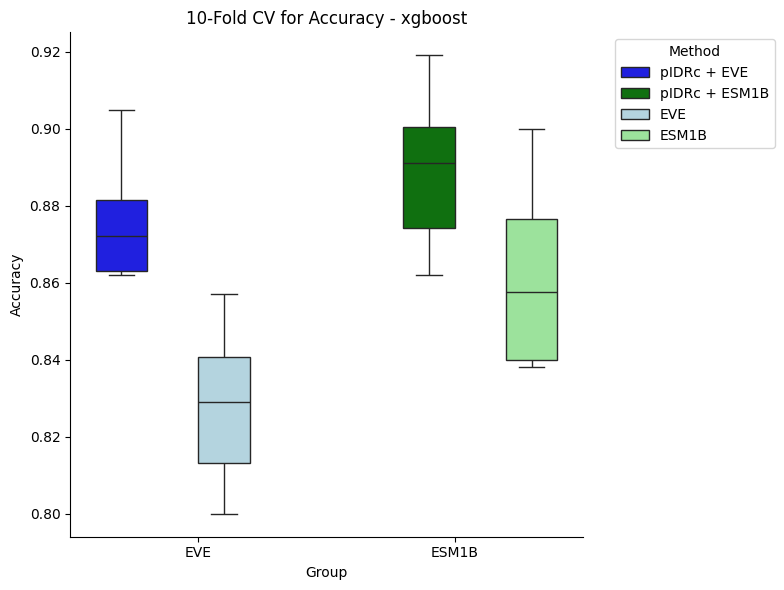

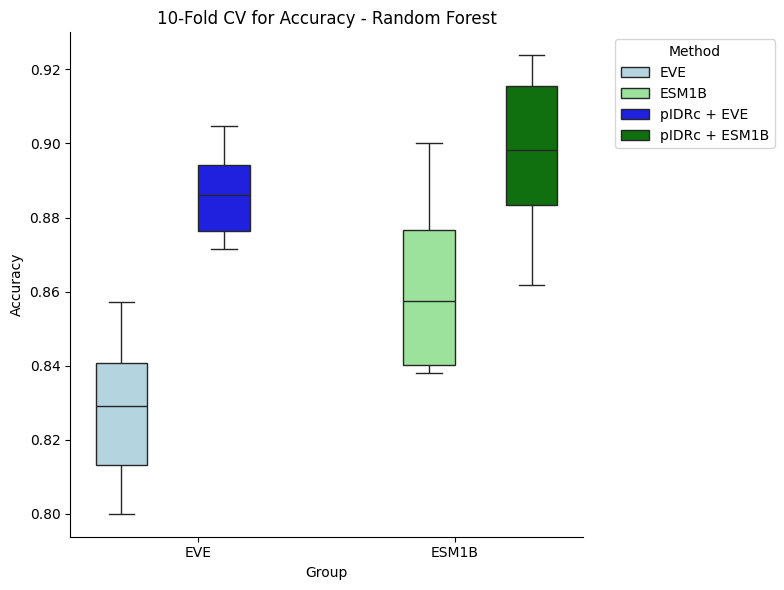

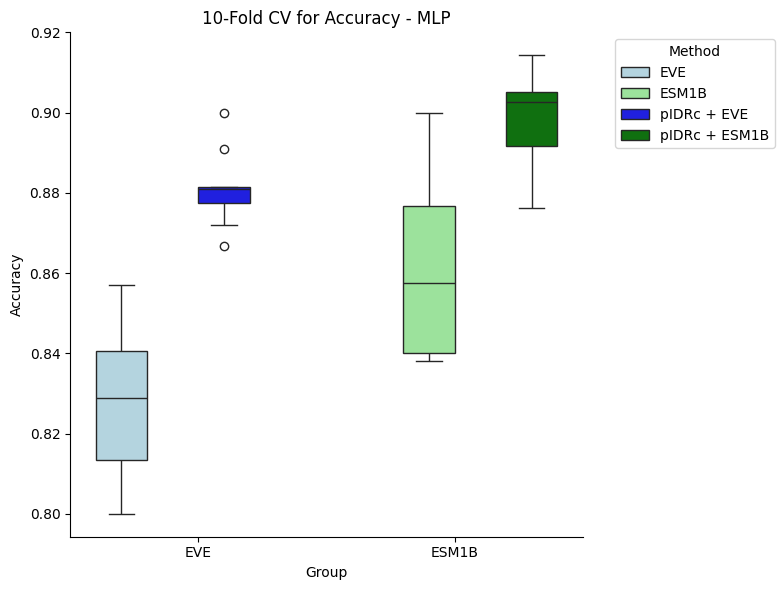

In [62]:
group1 = ['pIDRc + EVE', 'EVE']
group2 = ['pIDRc + ESM1B', 'ESM1B']
cv_results_df['group'] = cv_results_df['method'].apply(lambda x: 'EVE' if x in group1 else 'ESM1B')
#print(cv_results_xg_df)


models = ['xgboost', 'Random Forest', "MLP"]

# Define custom colors for the groups
custom_palette = {
    'pIDRc + EVE': 'blue',
    'EVE': 'lightblue',
    'pIDRc + ESM1B': 'green',
    'ESM1B': 'lightgreen'
}

# Create the grouped boxplot for accuracy
for model in models:
    data_df = cv_results_df[(cv_results_df['model'] == model) | (cv_results_df['model'] == 'ESM1B') | (cv_results_df['model'] == 'EVE')]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data_df, x='group', y='accuracy', hue='method', palette=custom_palette)
    plt.title(f'10-Fold CV for Accuracy - {model}')
    plt.xlabel('Group')
    plt.ylabel('Accuracy')
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add significance brackets for each group
    y_max = data_df['accuracy'].max()  # Maximum accuracy for y-axis scaling

    for group in ['EVE', 'ESM1B']:
        group_data = data_df[data_df['group'] == group]
        methods = group_data['method'].unique()

        if len(methods) > 1:
            method1, method2 = methods[0], methods[1]

            # Filter data for the two methods
            values1 = group_data[group_data['method'] == method1]['accuracy']
            values2 = group_data[group_data['method'] == method2]['accuracy']

            # Perform statistical test
            stat, p_value = ttest_ind(values1, values2)

            # Get x-axis positions for the methods
            x1 = data_df['method'].unique().tolist().index(method1)
            x2 = data_df['method'].unique().tolist().index(method2)

            # Add bracket
            #y, h, col = y_max + 0.02, 0.02, 'black'  # Adjust as needed
            #plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
            #plt.text((x1 + x2) * 0.5, y + h, f'p = {p_value:.3f}', ha='center', va='bottom', color=col)

    sns.despine()
    plt.tight_layout()
    plt.show()

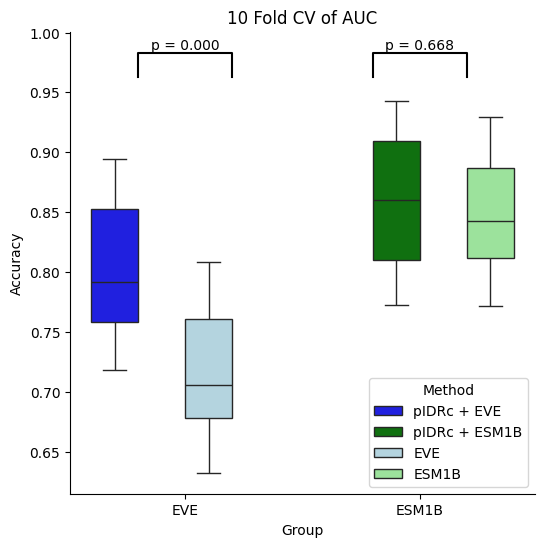

In [63]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=cv_results_df, x='group', y='auc', hue='method', palette=custom_palette)
plt.title('10 Fold CV of AUC')
plt.xlabel('Group')
plt.ylabel('Accuracy')
plt.legend(title='Method')



# Add significance brackets for each group
y_max = cv_results_df['auc'].max()  # Maximum accuracy for y-axis scaling

# Get x-axis positions for the groups and methods
group_positions = {group: i for i, group in enumerate(cv_results_df['group'].unique())}
method_positions = {method: i for i, method in enumerate(cv_results_df['method'].unique())}

for group in ['EVE', 'ESM1B']:
    # Get the methods in this group
    methods = cv_results_df[cv_results_df['group'] == group]['method'].unique()
    if len(methods) > 1:
        method1, method2 = methods[0], methods[1]

        # Filter data for the two methods
        values1 = cv_results_df[(cv_results_df['group'] == group) & (cv_results_df['method'] == method1)]['auc']
        values2 = cv_results_df[(cv_results_df['group'] == group) & (cv_results_df['method'] == method2)]['auc']

        # Perform statistical test
        stat, p_value = ttest_ind(values1, values2)

        # Get x positions for the methods
        x1 = group_positions[group] - 0.2  # Adjust for the first method
        x2 = group_positions[group] + 0.2  # Adjust for the second method

        # Add bracket
        y, h, col = y_max + 0.02, 0.02, 'black'  # Adjust as needed
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((x1 + x2) * 0.5, y + h, f'p = {p_value:.3f}', ha='center', va='bottom', color=col)

sns.despine()
plt.show()

In [64]:
#dbnsfpt_gene_df.to_csv("dbnsfp_data_disorder", sep='\t', index=None)

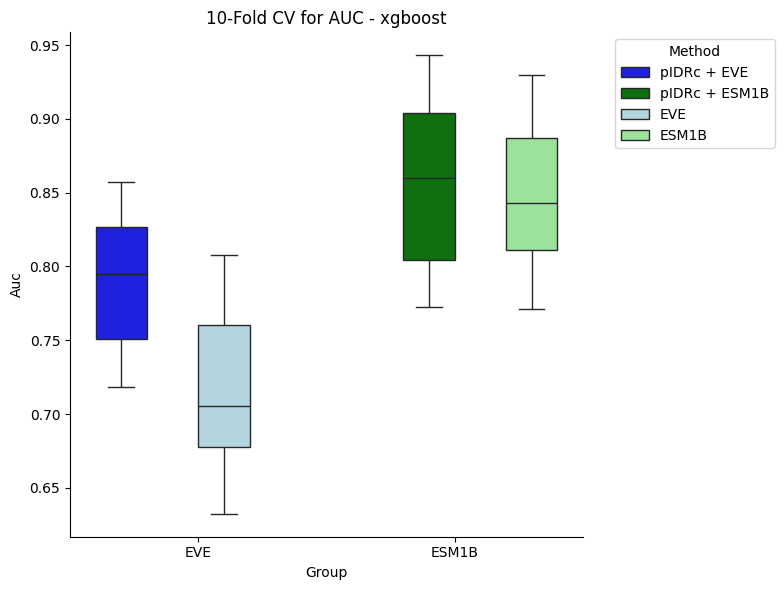

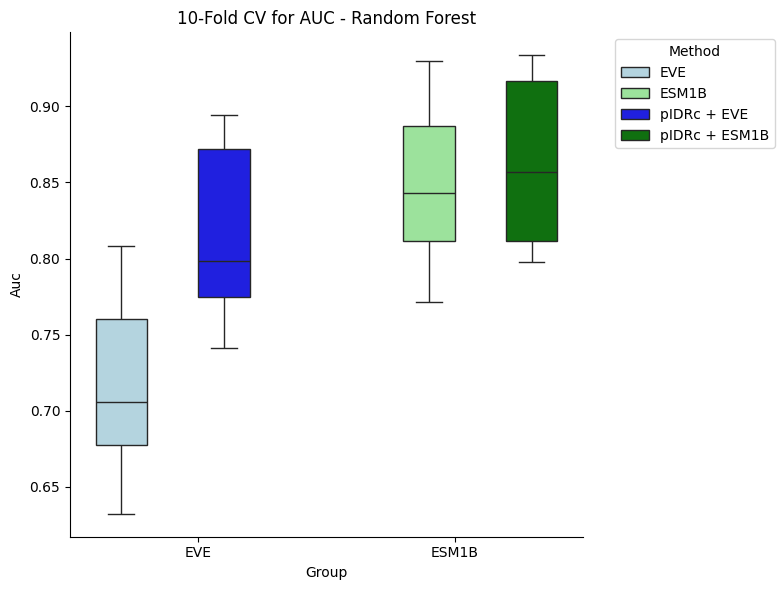

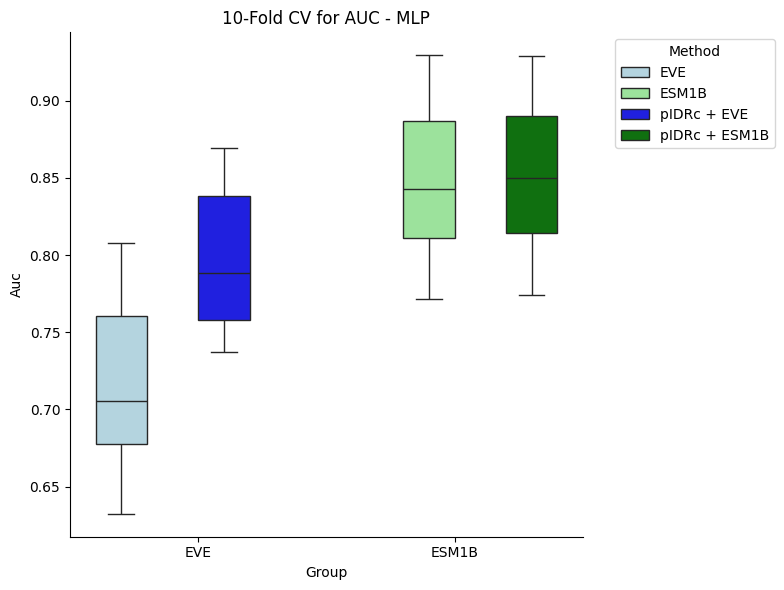

In [65]:
# Create the grouped boxplot for accuracy
for model in models:
    data_df = cv_results_df[(cv_results_df['model'] == model) | (cv_results_df['model'] == 'ESM1B') | (cv_results_df['model'] == 'EVE')]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data_df, x='group', y='auc', hue='method', palette=custom_palette)
    plt.title(f'10-Fold CV for AUC - {model}')
    plt.xlabel('Group')
    plt.ylabel('Auc')
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add significance brackets for each group
    y_max = data_df['auc'].max()  # Maximum accuracy for y-axis scaling

    for group in ['EVE', 'ESM1B']:
        group_data = data_df[data_df['group'] == group]
        methods = group_data['method'].unique()

        if len(methods) > 1:
            method1, method2 = methods[0], methods[1]

            # Filter data for the two methods
            values1 = group_data[group_data['method'] == method1]['auc']
            values2 = group_data[group_data['method'] == method2]['auc']

            # Perform statistical test
            stat, p_value = ttest_ind(values1, values2)

            # Get x-axis positions for the methods
            x1 = data_df['method'].unique().tolist().index(method1)
            x2 = data_df['method'].unique().tolist().index(method2)

            # Add bracket
            #y, h, col = y_max + 0.02, 0.02, 'black'  # Adjust as needed
            #plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
            #plt.text((x1 + x2) * 0.5, y + h, f'p = {p_value:.3f}', ha='center', va='bottom', color=col)

    sns.despine()
    plt.tight_layout()
    plt.show()

In [66]:
#AF2_disorder_dbnsfp_insilico_df
ref_ps_df = pd.read_csv(ref_ps_data, sep='\t')
mut_ps_df = pd.read_csv(mut_ps_data, sep='\t')
mut_ps_df = mut_ps_df.drop(['HydroPhobicIndex'], axis=1)
ref_ps_df = ref_ps_df.drop(['HydroPhobicIndex'], axis=1)
mut_cols = ['mut_' + i for i in mut_ps_df.columns.tolist()]
ref_cols = ['ref_' + i for i in ref_ps_df.columns.tolist()]
ref_ps_df.columns = ref_cols
mut_ps_df.columns = mut_cols


In [67]:
AF2_disorder_dbnsfp_insilico_ps_df = pd.merge(AF2_disorder_dbnsfp_insilico_df, mut_ps_df, left_on='mut_seq', right_on='mut_sequence')
AF2_disorder_dbnsfp_insilico_ps_df = pd.merge(AF2_disorder_dbnsfp_insilico_ps_df, ref_ps_df, left_on='WT', right_on='ref_sequence')


# Calculate delta values with better clarity
if len(mut_cols) != len(ref_cols):
    raise ValueError("The length of 'mut_cols' and 'ref_cols' must match.")

delta_columns = list(zip(mut_cols, ref_cols))
delta_columns = delta_columns[1:]

ps_cols = ref_cols + mut_cols
delta_ps_cols_list = [] 
for mut_col, ref_col in delta_columns:
    # Extract the common name for the delta column
    delta_name = f"abs_delta_{'_'.join(mut_col.split('_')[1:])}"
    delta_name = delta_name.replace("<-", "")
    # Compute the delta and add it as a new column
    AF2_disorder_dbnsfp_insilico_ps_df[delta_name] = (
        AF2_disorder_dbnsfp_insilico_ps_df[mut_col] 
        - AF2_disorder_dbnsfp_insilico_ps_df[ref_col]
    ).abs()
    delta_ps_cols_list.append(delta_name)
# Check for success
AF2_disorder_dbnsfp_insilico_ps_df.to_csv("../alphafold/AF2_disorder_all_features.csv", index=False)